# ***AdsorpSim*** 
## The ultimate tool for carbon capture !

#### Julian Barth, Marin Desgeans, Lucas Eichenberger


   

<div style="text-align: center;">
<img src="./images/Asterix.jpg" alt="UI" width="600"/>
</div>

Welcome to our documentation notebook for the package ***AdsorpSim***, an open source tool designed to generate breakthrough curves for direct air capture (DAC) of CO₂. It plays a critical role in tuning carbon capture machines and identifying the optimal adsorption time, accelerating the journey toward efficient climate solutions. It's an open source alternative to expensive softwares!

You may find below the table of contents to get a glimpse on the global structure of our project.

***Table of Contents***

1. Introduction
2. Presentation of the functions
3. Data Usage
4. Presentation of the UI and the different app's tools 
5. Conclusion ?
6. Acknowledgments


### 1. Introduction
The fight against climate change is urgent and relentless. To limit global warming to **1.5°C**, the world must remove over **10 billion tons of CO₂ every year by 2050**. That means not only cutting current emissions, but also dealing with past emissions that remain in the atmosphere. Technologies that actively remove CO₂ from the air are no longer optional: they’re essential.

One of the most promising of these technologies is Direct Air Capture (DAC), which captures CO₂ directly from the air, where it exists at extremely low concentrations, **around 400 parts per million**. That makes the challenge particularly difficult: extracting a trace gas from a massive volume of air requires both smart materials and smart system design.

At EPFL, the Carbon Team, a student-led group, is tackling this challenge head-on. One of its prototype systems, named Asterix (see picture above), captures CO₂ using **solid adsorbents**: materials that selectively trap CO₂ as air flows through them. These systems rely on a packed adsorbent bed, typically modeled as a cylindrical column filled with porous particles. As air is pushed through the column, CO₂ is gradually removed until the adsorbent becomes saturated.

<figure style="text-align: center;">
  <img src="./images/FlowSheet.png" alt="Flow Diagram" style="max-width: 600px; width: 100%; height: auto;" />
  <figcaption> Schematic of the Carbon team's full process (we will only focus on Asterix).</figcaption>
</figure>

**Designing such systems is complex**. Performance depends on many variables: the type of adsorbent, the bed height, particle size, flow rate, inlet concentration, and more. Building and testing every possible configuration in the lab would be time-consuming and expensive.

**That’s where our project comes in.**

We developed an interactive, open-source simulator that lets the Carbon Team experiment with different system designs and adsorbent materials, all in a matter of seconds. With this tool, users can:

- Simulate CO₂ adsorption over time using different materials
- Modify system parameters like bed dimensions, particle diameter, and inlet flow rate
- Visualize performance using a breakthrough curve
- Estimate the total amount of CO₂ captured over a specified period

The breakthrough curve is a key output of the simulator. It shows how the outlet CO₂ concentration changes over time. At the start, the adsorbent captures nearly all the CO₂, so the outlet concentration is near zero. As the bed becomes saturated, CO₂ begins to break through — hence the name. This curve is fundamental for assessing the efficiency and capacity of the system.

One of the simulator’s biggest strengths is that it’s **open-source and easily customizable**. Unlike commercial alternatives such as Aspen Adsorption, which costs up to $20,000 per year and offers limited flexibility, our tool is free to use, modify, and share. That makes it ideal for student teams, researchers, and early-stage innovators who need speed, flexibility, and transparency.

---


### 2. Approach to the problem

### A little theory: Modelling of an adsobant bed

#### Langmuir Isotherm Explanation

The **Langmuir Isotherm** describes how molecules adsorb onto a solid surface forming a monolayer. It assumes:

- A fixed number of adsorption sites,  
- Each site holds at most one molecule,  
- No interaction between adsorbed molecules.

The equilibrium adsorbed amount $q_{eq}$ relates to the gas-phase concentration $C$ as:

$$
q_{eq} = \frac{q_{\max} K C}{1 + K C}
$$

where:

- $q_{eq}$ is the equilibrium adsorbed amount (mol/kg),  
- $q_{\max}$ is the maximum adsorption capacity (monolayer coverage),  
- $K$ the Langmuir equilibrium constant (related to affinity),  
- $C$ is the gas-phase concentration (e.g., mol/m³).


#### Spacial discretization of the adsorbant bed

An adsorbant bed has the geometry of a cylinder. To numerically simulate adsorption along it, we discretize it into multiple segments (`num_segments`). Concentration gradients are approximated by **upwind finite differences**, assuming plug flow (no axial mixing):

$$
\frac{\partial C}{\partial z} \approx \frac{C_i - C_{i-1}}{\Delta z}
$$

where

$$
\Delta z = \frac{\text{bed length}}{\text{number of segments}}
$$

This spatial discretization transforms PDEs into ODEs solvable by standard methods.


#### Mathematical Model Summary

And now for the mother of all equations: **mass balance**.

For each gas component (CO₂ or H₂O), the mass balance in segment i is:

$$
\frac{dC_i}{dt} = -v \frac{C_i - C_{i-1}}{\Delta z} - \rho_b \frac{dq_i}{dt}
$$

where:

- $C_i$: concentration in segment $i$ ($mol/m^3$),  
- $v$: superficial gas velocity ($m/s$),
- $\Delta z$: segment length ($m$),  
- $\rho_b$: bulk density of adsorbent ($kg/m^3$),  
- $q_i$: adsorbed amount in segment $i$, evolving by Langmuir kinetics ($mol/m^3$):  

$$\frac{dq_i}{dt} = k_{\text{ads}} (q_{eq,i} - q_i)$$


with $q_{eq,i}$ given by the Langmuir isotherm and $k_{ads}$ the adosprtion rate constant (1/s)

So how does that translate to code?

### Workflow

Let's first understand the experiment workflow.


1) The user first **defines an adsorbent** by specifying its Langmuir parameters (e.g., maximum adsorption capacity, equilibrium constant, adsorption rate, and density).

2) The user **initializes a bed** by providing its geometry, flow conditions, the adsorbent object and optionally humidity. Spacial discretization parameters are given.

3) The user calls the **`simulate()` method** to run the adsorption process over the specified time. 

4) The simulation outputs concentration profiles at the bed outlet, which the user can **plot and analyze** (e.g., breakthrough curves for CO₂ and H₂O).

<figure style="text-align: center;">
  <img src="./images/schema.png" alt="Flow Diagram" style="max-width: 300px; width: 100%; height: auto;" />
  <figcaption> Simplified process flow scheme</figcaption>
</figure>

#### How to Use

Enough theory: let's get to coding!

**Step 1** : Let's import the right libraries, the needed classes and our different functions.

In [213]:
%matplotlib inline
import sys
from pathlib import Path
import streamlit as st
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import solve_ivp
import pandas as pd
import os

from adsorpsim import (
    Adsorbent_Langmuir,
    Bed,
    download_data,
    get_percentage_point,
    plot_the_graph,
    add_adsorbent_to_list,
    get_adsorbed_quantity_CO2,
    get_adsorbed_quantity_H2O,
    fit_adsorption_parameters_from_df,
    load_adsorbent_from_csv
)

ImportError: cannot import name 'fit_adsorption_parameters_from_df' from 'adsorpsim.core' (C:\Users\eiche\Documents\AdsorpSim\src\adsorpsim\core.py)

**Step 2** : Let's define an adsorbent. We define an object of the `Adsorbent_ Langmuir` class, filling in the properties using the Langmuir model. We'll use the example of activated carbon. 

In [ ]:
carbon = Adsorbent_Langmuir(
    name="Activated Carbon",
    q_max_CO2=4.5, #mol/kg
    K_CO2=0.2, #1/(mol/m^3)
    k_ads_CO2=15, #(1/s)
    density=500, #kg/m^3
    q_max_H2O=4.0, #mol/kg
    K_H2O=0.1, #1/(mol/m^3)
    k_ads_H2O=0.5 #(1/s)
    )

**Step 3** : Set up the reactor. With the adsorbent object ready, we can now configure a packed-bed reactor to model the breakthrough curve by filling in the `Bed` class. The code, will use the data given to calculate velocity, segment size and inital gas concentratinos. Concentration and adsoption arrays are also initialized. We will start by modelling adsorption with dry air, and the reactor used by the Carbon Team

In [ ]:
Reactor = Bed(
    length=1.0, # m
    diameter=0.1, # m 
    flow_rate=0.01, # m/s
    num_segments=100, # discretization parameter
    total_time=1000, # s
    adsorbent=carbon, #Adsrobent_Langmuir object
)

**Step 4** : Let’s run the simulation using the `simulate()` method. The code converts the PDE describing concentration changes into ODEs using spatial discretization and solves them over time. This is achieved using  the integration feature from Scipy. This will generate 2 arrays: time and the concentration of CO2 at the outlet in mol/m^3. We'll print the first few elements

In [ ]:
t, outlet_CO2, outlet_H2O = Reactor.simulate()

print("t:", t[:5])
print("outlet_CO2:", outlet_CO2[:5])

t: [0.       1.001001 2.002002 3.003003 4.004004]
outlet_CO2: [0.00000000e+000 1.29624864e-134 1.00868127e-126 4.92876587e-121
 1.07018127e-113]


We now need to make some sense out of this data, which can be plotted using the `plot_the_graph` function. 

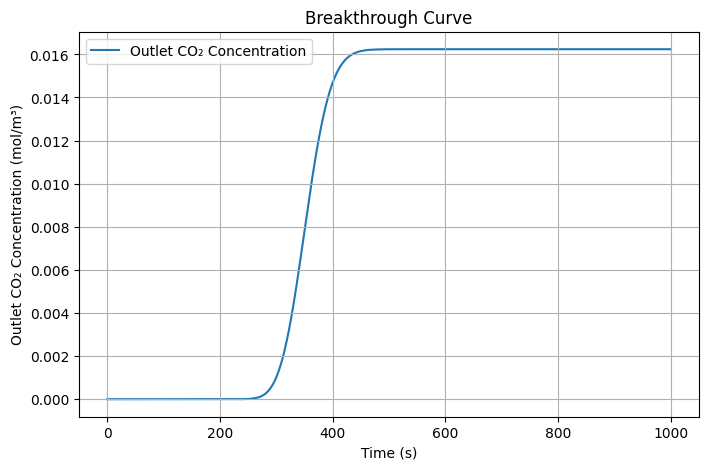

In [ ]:
fig=plot_the_graph(t,outlet_CO2,outlet_H2O)

The graph by istelf looks nice, but it's missing some key information. After discussion with the Carbon Team, and important criteria for them is to identify the saturation level of adsorbant (in %), to find the optimal adsorption time. The `get_percentage_point`function find the corresponding point on the curve (time, outlet CO2 concentration). We can then use this data to drawer a plot with more information. 

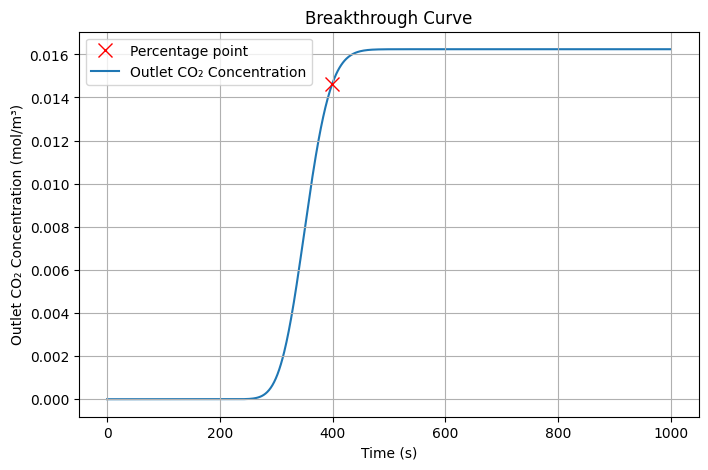

In [ ]:
wanted_percentage=90
pc_point_time, pc_point_concentration = get_percentage_point(wanted_percentage,t,outlet_CO2)
fig=plot_the_graph(t,outlet_CO2,outlet_H2O, pc_point_time, pc_point_concentration)

**Step 5**: Now that we know when the system reaches our desired saturation, we can compute the amount of CO2 captured. This also gives us the experiment time. For this we use the `get_adsorbed_quantity_CO2`function which gives us the amount of CO2 captured in moles. 

In [ ]:
adsorbed_quantity_CO2=get_adsorbed_quantity_CO2(outlet_CO2,pc_point_time,pc_point_concentration,Reactor.flow_rate)
print(f"{round(adsorbed_quantity_CO2*0.044009, 2)} [kg] of CO₂ is adsorbed in one cycle of {round(pc_point_time/60, 2)} [min]")

1.0 [kg] of CO₂ is adsorbed in one cycle of 6.66 [min]


If we change the wanted percentage of saturated adsorbent, the value changes.

In [ ]:
wanted_percentage=60
pc_point_time, pc_point_concentration = get_percentage_point(wanted_percentage,t,outlet_CO2)
adsorbed_quantity_CO2=get_adsorbed_quantity_CO2(outlet_CO2,pc_point_time,pc_point_concentration,Reactor.flow_rate)
print(f"{round(adsorbed_quantity_CO2*0.044009, 2)} [kg] of CO₂ is adsorbed in one cycle of {round(pc_point_time/60, 2)} [min]")

0.89 [kg] of CO₂ is adsorbed in one cycle of 6.02 [min]


A common problem which is often faced is the dual adsdsorption of water, which can't be negliged. Matter of fact, CO2 and H2O are pretty similiar molecules. That said, it was particularly important to add the humidty of air as an initial parameter. This can be computed by filling the `humidity_percentage` in the `Bed`class. We then use the same procedure as before to get adsobed quantity and time. we also get a dual breakthrough curve. The amount of H2O captured can't be found using the `get_adsorbed_quantity_H2O`function.

1.0 [kg] of CO₂ and 0.1 [kg] of H₂O are adsorbed in one cycle of 6.66 [min]


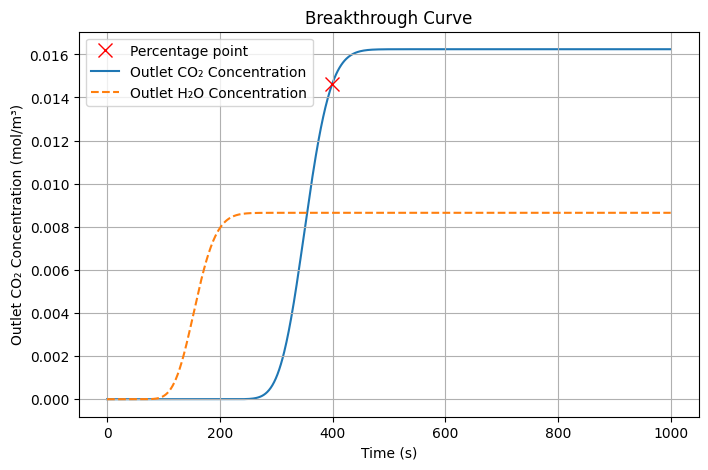

In [ ]:
wet_reactor = Bed(
    length=1.0,
    diameter=0.1,
    flow_rate=0.01,
    num_segments=100,
    total_time=1000,
    adsorbent=carbon,
    humidity_percentage=50
)

t, outlet_CO2, outlet_H2O = wet_reactor.simulate()

wanted_percentage=90
pc_point_x, pc_point_y = get_percentage_point(wanted_percentage,t,outlet_CO2)
fig=plot_the_graph(t,outlet_CO2,outlet_H2O,pc_point_x,pc_point_y)

adsorbed_quantity_CO2=get_adsorbed_quantity_CO2(outlet_CO2,pc_point_x,pc_point_y,wet_reactor.flow_rate)
adsorbed_quantity_H2O=get_adsorbed_quantity_H2O(outlet_CO2,outlet_H2O,wet_reactor.humidity_percentage,pc_point_x,pc_point_y,wet_reactor.flow_rate)
print(f"{round(adsorbed_quantity_CO2*0.044009, 2)} [kg] of CO₂ and {round(adsorbed_quantity_H2O*0.018015, 2)} [kg] of H₂O are adsorbed in one cycle of {round(pc_point_x/60, 2)} [min]")

### Data Usage

AdsorpSim also gives the user access to a small pool of pre-defined adsorbants found in litterature that can directly be tested out. These can be found in the '/dataAdsorbent_data.csv' file. It contains all parameters necessary to test out an adsorbant  

In [ ]:
print(download_data('../data/Adsorbent_data.csv'))

               name  q_max_CO2  K_CO2  k_ads_CO2  density  q_max_H2O  K_H2O  \
0  Activated Carbon        5.0    0.2       0.02    800.0        3.0  0.001   

   k_ads_H2O  
0        0.1  


From this an `Adsorbent_Langmuir`object can easily be created using the `load_adsorbent_from_csv` functio. These adsorbents can thus be used to run simulations

In [ ]:
csv_path = '../data/Adsorbent_data.csv'
adsorbent = load_adsorbent_from_csv(csv_path=csv_path, adsorbent_name= 'Activated Carbon')
print(adsorbent)

Activated Carbon (q_max_CO2=5.0, K_CO2=0.2, k_ads_CO2=0.02, density=800.0, q_max_H2O=3.0, K_H2O=0.001, k_ads_H2O=0.1)


Adsorbents can also be added to the dataset using `add_adsorbent_to_list`.

In [ ]:
add_adsorbent_to_list(
    CSV_PATH = '../data/Adsorbent_data.csv' , 
    name= 'Zeolite 13X', 
    q_max_CO2= 5.5, 
    K_CO2 = 0.6, 
    k_ads_CO2 = 0.05, 
    density = 750,
    q_max_H2O = 1.5, 
    K_H2O = 0.001, 
    k_ads_H2O= 0.15)

print(download_data('../data/Adsorbent_data.csv'))

               name  q_max_CO2  K_CO2  k_ads_CO2  density  q_max_H2O  K_H2O  \
0  Activated Carbon        5.0    0.2       0.02    800.0        3.0  0.001   
1       Zeolite 13X        5.5    0.6       0.05    750.0        1.5  0.001   
2       Zeolite 13X        5.5    0.6       0.05    750.0        1.5  0.001   
3       Zeolite 13X        5.5    0.6       0.05    750.0        1.5  0.001   
4       Zeolite 13X        5.5    0.6       0.05    750.0        1.5  0.001   

   k_ads_H2O  
0       0.10  
1       0.15  
2       0.15  
3       0.15  
4       0.15  


## Finding adsorbent properties

Litterature has its limits, and data can be limited. The Carbon Team also runs its own tests with customised adsobants: 
What if we have the breakthrough values for an adorbant and want to find its properties? It is possible to use AdsorpSim's regression tool to find them! 

To do this we will use the `bed` class but since we don't know the properties of the adorbent we will specifiy it as "None". We the use the `fit_adsorption_parameters_from_df` function in which we insert the dataframe coressponding to experminental data, a bed and the assumed density of the adsorbent. The code then finds the optimal parameters that will yield the smallest squared error using scipys `minimize`function. 

It will return the fitted adsorbent parameters as well as the fitted graph. 

In [215]:
data_df = pd.read_csv('../data/lab_data.csv', sep=',')
# Create a dummy adsorbent to build the bed template (values don't matter here)

# Create a bed template with the dummy adsorbent
bed_template = Bed(
    length=1,            # bed length in meters
    diameter=0.1,         # bed diameter in meters
    flow_rate=0.01,        # flow rate in m³/s
    num_segments=100,       # discretization segments
    total_time=2000,         # total simulation time in seconds
    adsorbent=None
)

# Now call the fitting function
fitted_adsorbent, fig = fit_adsorption_parameters_from_df(data_df, bed_template, assumed_density=800)

print("Fitted Adsorbent Parameters:")
print(fitted_adsorbent)

TypeError: Bed.__init__() missing 1 required positional argument: 'T'

### The "Adsorpsim" app

Now that we have presented how our code works, we will present how we made the different possibilities of our project user friendly via a streamlit interface. 



### 3.Presentation and extraction of the data

The data for this app is presented in the csv file: Dataset PPC.csv. This file contains a list of adsorbent and their physical properties needed to draw the breakthrough curve. The file is organised as follows: each row represents one adsorbent.

|name     | q_max | K0   | Ea   | k_ads | density |
|--------------------|------|---------|---------|-------|--------|
| Activated Carbon   | 2.0  | 20000.0 | 25000.0 | 0.01  | 1000.0 |
| Activated Carbon2  | 1.0  | 10000.0 | 12500.0 | 0.02  | 500.0  |
| Activated Carbon3  | 1.0  | 10000.0 | 12500.0 | 0.002 | 500.0  |


The loading of the data is essential for the proper functionning of the app. Additionnaly, a dictionnary indexed by the adsorbent's name is created with an entry for each adsorbent. This dictionnary will be used to display the good physical constants for the graph when one or another adsorbent is chosen on the list.

Additionally, a list of the adsorbents' names is created. This list will be used to propose to the user the usage of the different adsorbents.

### 4. Presentation of the UI and the different app's tools 

In this chapter, the different elements in the user's interface and their utility will be described as follows: 

<ol type="a">
    <li> The bed parameters modifications </li>
    <li> The adsorbent parameters modifications</li>
    <li> The plotting of the graph</li>
    <li> The adsorbed quantity of carbon dioxide</li>
    <li> The possibility to add an adsorbent to the data</li> 
</ol>

#### a. The bed parameters modifications

<div style="text-align: center;">
<img src="Bed.png" alt="UI" width="400"/>
</div>

The user is let to choose the bed parameters. This parameters are defined by different sliders with maximum and minimum values. The temperature is defined with a "number_input" widget. 

The bed length and diameter changes the volume of the installation whiyh changes the total quantity of adsorbent as we assume that the bed is full of material. 

The flowrates influence the speed at which the air is let trhough the cartridge. For optimal results, the flowrate should not exceed the speed of the adsorption reaction. 

The number of segments determines the discretisation of the bed. A higher number of esegemnts will allow more precise results but implies more complex calculations.

The total time determines the time of the experiment. 

T is the temperature of the experiment. Colder temperatures will favorize adsorption while hotter temperature will accelerate the desorption.

And finally, the "percentage_CO2" is defined between 1 and 100% and represents the desired percentage of adsorbent saturated in CO₂. This value is used to calculate the coordinates of the red cross. 

#### b. The adsorbent parameters modifications

<div style="text-align: center;">
<img src="List.png" alt="UI" width="400"/>
</div>

Five physical properties are mandatory for each adsorbent:

-q_max represents...

-K0 ...

-Ea is the activation energy of the adsorbent, ...

-k_ads ...

-density is the density of the adsorbent is directly proportionate to the quantity of adsorbent in one cartridge.

The user is let to choose one adsorbent among the different species present in the dataset. Each adsorbent is linked to its properties: choosing one will automatically insert the good values for each physical property. 

The user also have the choice to choose "Manual Modifications". In this case, the user can modify the different parameters from the user's interface and curve will adapt with the implemented values.

#### c. The plotting of the graph

<div style="text-align: center;">
<img src="Graph.png" alt="UI" width="400"/>
</div>

Different previously presented functions are called to draw the breakthrough curve. The red cross is here observed at the point were 90% of the adsorbent is saturated in CO₂.

#### d. The adsorbed quantity of carbon dioxide

<div style="text-align: center;">
<img src="Quantities.png" alt="UI" width="400"/>
</div>

The adsorbed quantity of CO₂ is calculated in moles using the previously presented function. The quantity in kilogramms is easily calculated using CO₂ molar mass. The needed time, which corresponds to the x coordinate of the red cross is also displayed. 

All these values are impacted by both the bed and the adsorbent parameters. Changing on of them will directly recalculate the different quantities, exhibiting the efficiency of the chosen system. 

#### e. The possibility to add an adsorbent to the data

<div style="text-align: center;">
<img src="Add.png" alt="UI" width="400"/>
</div>

Finally, the user is let to add an adsorbent to the list directly from the app. In order to do this, he must fill the differents widgets, giving the name and the physical properties of the adsorbent. If he forgets one an error message will show up, otherwise, the adsorbent will successfully be added to the dataset and will be available for usage after a quick refresh of the page.

#### f. The possibility to deduct an adsorbent's parameters from a experimental breakthrough curve

### 5. Conclusion



### 6. Acknowledgments

We thank the **EPFL Carbon Team**, especially the Chemistry subteam Panoramix, for providing experimental data acquired in **Professor Wendy Queen’s** lab. Their contributions were essential for validating and grounding our simulator in real-world performance.